### REDDIT MENTAL HEALTH DISCUSSIONS ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from bertopic import BERTopic

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

import nbformat

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN

from empath import Empath


c:\Users\carru\Desktop\css project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### 1. EXPLORATORY DATA ANALYSIS

Let's start by accessing the folder in which cleaned data are stored, then proceed to extract:
- engagement metrics
- unigrams and bigrams

A list of stopwords is needed in order to exclude from the analysis common, irrelevant words or words related to bots.

In [2]:
# for reproducibility
seed = 77

# likely bot, common or irrelevant words
custom_stopwords = [
    "thank", "please", "questions", "action", "appropriate", "subscribe", 
    "check", "link", "bio", "automatically", "bot", "post", "feel", "like"
]
stop_words = list(stopwords.words('english')).__add__(custom_stopwords)

In [3]:
# main path for saving data, not visible in the repo to protect privacy
root_path = "../references/"

# Folders with cleaned post and comment files
cleaned_data_folder = "../references/data_cleaned/"

# lists to store metrics and n-gram frequencies
metrics_list = []
unigram_freqs = []
bigram_freqs = []

# Loop through relevant files only
for file in os.listdir(cleaned_data_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(cleaned_data_folder, file)
        df = pd.read_csv(file_path)

        if "post" in file:
            text_type = "posts"
            text_col = "clean_text"
            id_col = "post_id"
        elif "comment" in file:
            text_type = "comments"
            text_col = "clean_text"
            id_col = "comment_id"
        else:
            continue

        subreddit_name = file.replace(f"cleaned_", "").replace(f"_{text_type}.csv", "")

        # Filter out bot content in comments. Rudimentary check for bot-generated content, later replaced by stop words
        if text_type == "comments":
            bot_phrases = ["bot action", "performed automatically", "action performed"]
            for phrase in bot_phrases:
                df = df[~df[text_col].str.contains(phrase, case=False, na=False)]

        # Compute engagement metrics only for posts (we don't need comments)
        if text_type == "posts":
            avg_comments = df["num_comments"].mean()
            median_comments = df["num_comments"].median()
            std_comments = df["num_comments"].std()
            median_upvotes = df["score"].median()
            max_upvotes = df["score"].max()
            max_comments = df["num_comments"].max()
            avg_text_length = df["selftext"].dropna().apply(lambda x: len(x.split())).mean()
            unique_users = df["author"].nunique()

            # Append results
            metrics_list.append({
                "posts_origin": subreddit_name,
                "avg_comments": round(avg_comments, 2),
                "median_comments": round(median_comments, 2),
                "std_comments": round(std_comments, 2),
                "median_upvotes": round(median_upvotes, 2),
                "max_number_of_upvotes": int(max_upvotes),
                "max_number_of_comments": int(max_comments),
                "avg_text_length": round(avg_text_length, 2),
                "unique_users": int(unique_users),
                "text_type": text_type
            })

        # Check if clean_text column exists and is not empty
        if text_col in df.columns and df[text_col].notna().any():
            texts = df[text_col].dropna()

            # Unigrams extracted by a vectorizer
            vectorizer_uni = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words, max_features=10)
            X_uni = vectorizer_uni.fit_transform(texts)
            words_uni = vectorizer_uni.get_feature_names_out()
            counts_uni = X_uni.sum(axis=0).A1  

            for word, count in zip(words_uni, counts_uni):
                unigram_freqs.append({
                    "posts_origin": subreddit_name,
                    "text_type": text_type,
                    "unigram": word,
                    "frequency": int(count)
                })

            # Bigrams
            vectorizer_bi = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words, max_features=10)
            X_bi = vectorizer_bi.fit_transform(texts)
            words_bi = vectorizer_bi.get_feature_names_out()
            counts_bi = X_bi.sum(axis=0).A1

            for phrase, count in zip(words_bi, counts_bi):
                bigram_freqs.append({
                    "posts_origin": subreddit_name,
                    "text_type": text_type,
                    "bigram": phrase,
                    "frequency": int(count)
                })

# Convert to DataFrames
metrics_df = pd.DataFrame(metrics_list).sort_values(by=["posts_origin", "text_type"]).reset_index(drop=True)
unigrams_df = pd.DataFrame(unigram_freqs).sort_values(by=["posts_origin", "text_type", "frequency"], ascending=[True, True, False]).reset_index(drop=True)
bigrams_df = pd.DataFrame(bigram_freqs).sort_values(by=["posts_origin", "text_type", "frequency"], ascending=[True, True, False]).reset_index(drop=True)

os.makedirs(os.path.join(root_path, "tables_figures"), exist_ok=True)

metrics_df.to_csv(os.path.join(root_path, "tables_figures/metrics.csv"), index=False)
unigrams_df.to_csv(os.path.join(root_path, "tables_figures/unigrams.csv"), index=False)
bigrams_df.to_csv(os.path.join(root_path, "tables_figures/bigrams.csv"), index=False)

# the whole dataset is diplayed
metrics_df.head(10)

,posts_origin,avg_comments,median_comments,std_comments,median_upvotes,max_number_of_upvotes,max_number_of_comments,avg_text_length,unique_users,text_type
0,Anxiety,5.57,2.0,22.25,1.0,4234,552,183.04,852,posts
1,Anxietyhelp,4.91,2.0,11.61,1.0,277,199,199.47,740,posts
2,all_posts_combined.csv,4.07,2.0,12.86,2.0,4234,552,201.00,4059,posts
3,depression,3.02,1.0,9.78,2.0,365,196,217.24,908,posts
4,depression_help,3.73,3.0,4.23,2.0,84,57,199.26,777,posts
5,mentalhealth,3.26,1.0,9.42,1.0,268,113,204.74,893,posts


Overall the subreddits share various similarities, such as the median of comments, median of upvotes and the average text length. engagement is not that high, but there are some situations in which it becomes suddenly higher, as noticeable by looking at the max number of comments and upovtes, likely happening in highly discussed posts. the first subreddit in particular has noticeable extremes.
The average text length is balanced across all subreddits, being around 200 and suitable for the next analyses.

the r/Anxiety subreddit shows an high max number of comments under a single post. I've decided to not treat this kind of posts as outliers and cut them, because keeping them would reflect the actual dynamics of online platforms more, keeping the nature of these communities intact. 



In [4]:
unigrams_df.groupby(["posts_origin", "text_type"]).head(3)

,posts_origin,text_type,unigram,frequency
0,Anxiety,comments,anxiety,1178
1,Anxiety,comments,get,721
2,Anxiety,comments,time,503
10,Anxiety,posts,anxiety,1240
11,Anxiety,posts,get,636
12,Anxiety,posts,know,586
20,Anxietyhelp,comments,anxiety,929
21,Anxietyhelp,comments,get,547
22,Anxietyhelp,comments,things,397
30,Anxietyhelp,posts,anxiety,1301


In [5]:
bigrams_df.groupby(["posts_origin" , "text_type"]).head(5)

,posts_origin,text_type,bigram,frequency
0,Anxiety,comments,panic attacks,107
1,Anxiety,comments,panic attack,98
2,Anxiety,comments,side effects,82
3,Anxiety,comments,mental health,75
4,Anxiety,comments,health anxiety,62
10,Anxiety,posts,panic attacks,141
11,Anxiety,posts,anyone else,107
12,Anxiety,posts,panic attack,104
13,Anxiety,posts,dont know,87
14,Anxiety,posts,even though,65


Unigrams alone are not that helpful, the only insight seems to be the word "anxiety" appearing in the related subs. Bigrams on the contrary show interesting pairs:
- panic attack and side effects (probably referred to medcines) are a common topic of discussion, especially but not only in the anxiety related subs.
- the pair "get better" is more related to the depression subs, and makes sense, since people are seeking support there.

#### 2. GENERAL TOPIC MODELING

In [6]:
#nltk.download('stopwords')
# --- configuration ---
NUM_TOPICS = 10
MAX_FEATURES = 3000
TOP_N_WORDS = 10

# we just need the combination of all posts and comments
posts_comments = ["cleaned_all_comments_combined.csv", "cleaned_all_posts_combined.csv"]

vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=5,
        max_features=MAX_FEATURES,
        stop_words=stop_words
    )
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she


 Running LDA for POSTS (4649 documents)

 Topic 1: know | people | really | gon | idk | scared | someone | help | said | get

 Topic 2: cant | dont | want | life | know | anymore | hate | even | everything | fucking

 Topic 3: got | even | know | started | one | back | felt | time | went | told

 Topic 4: even | anxiety | something | people | one | feels | thoughts | real | someone | know

 Topic 5: work | get | time | things | job | day | dont | ive | cant | really

 Topic 6: dont | want | know | people | ive | think | cant | even | really | always

 Topic 7: depression | mom | help | therapy | parents | want | dad | get | know | really

 Topic 8: life | even | want | know | get | never | friends | time | years | one

 Topic 9: anxiety | panic | get | heart | feeling | anxious | attack | attacks | anyone | going

 Topic 10: anxiety | taking | sleep | take | medication | get | day | years | started | days
 Coherence Score: 0.4236


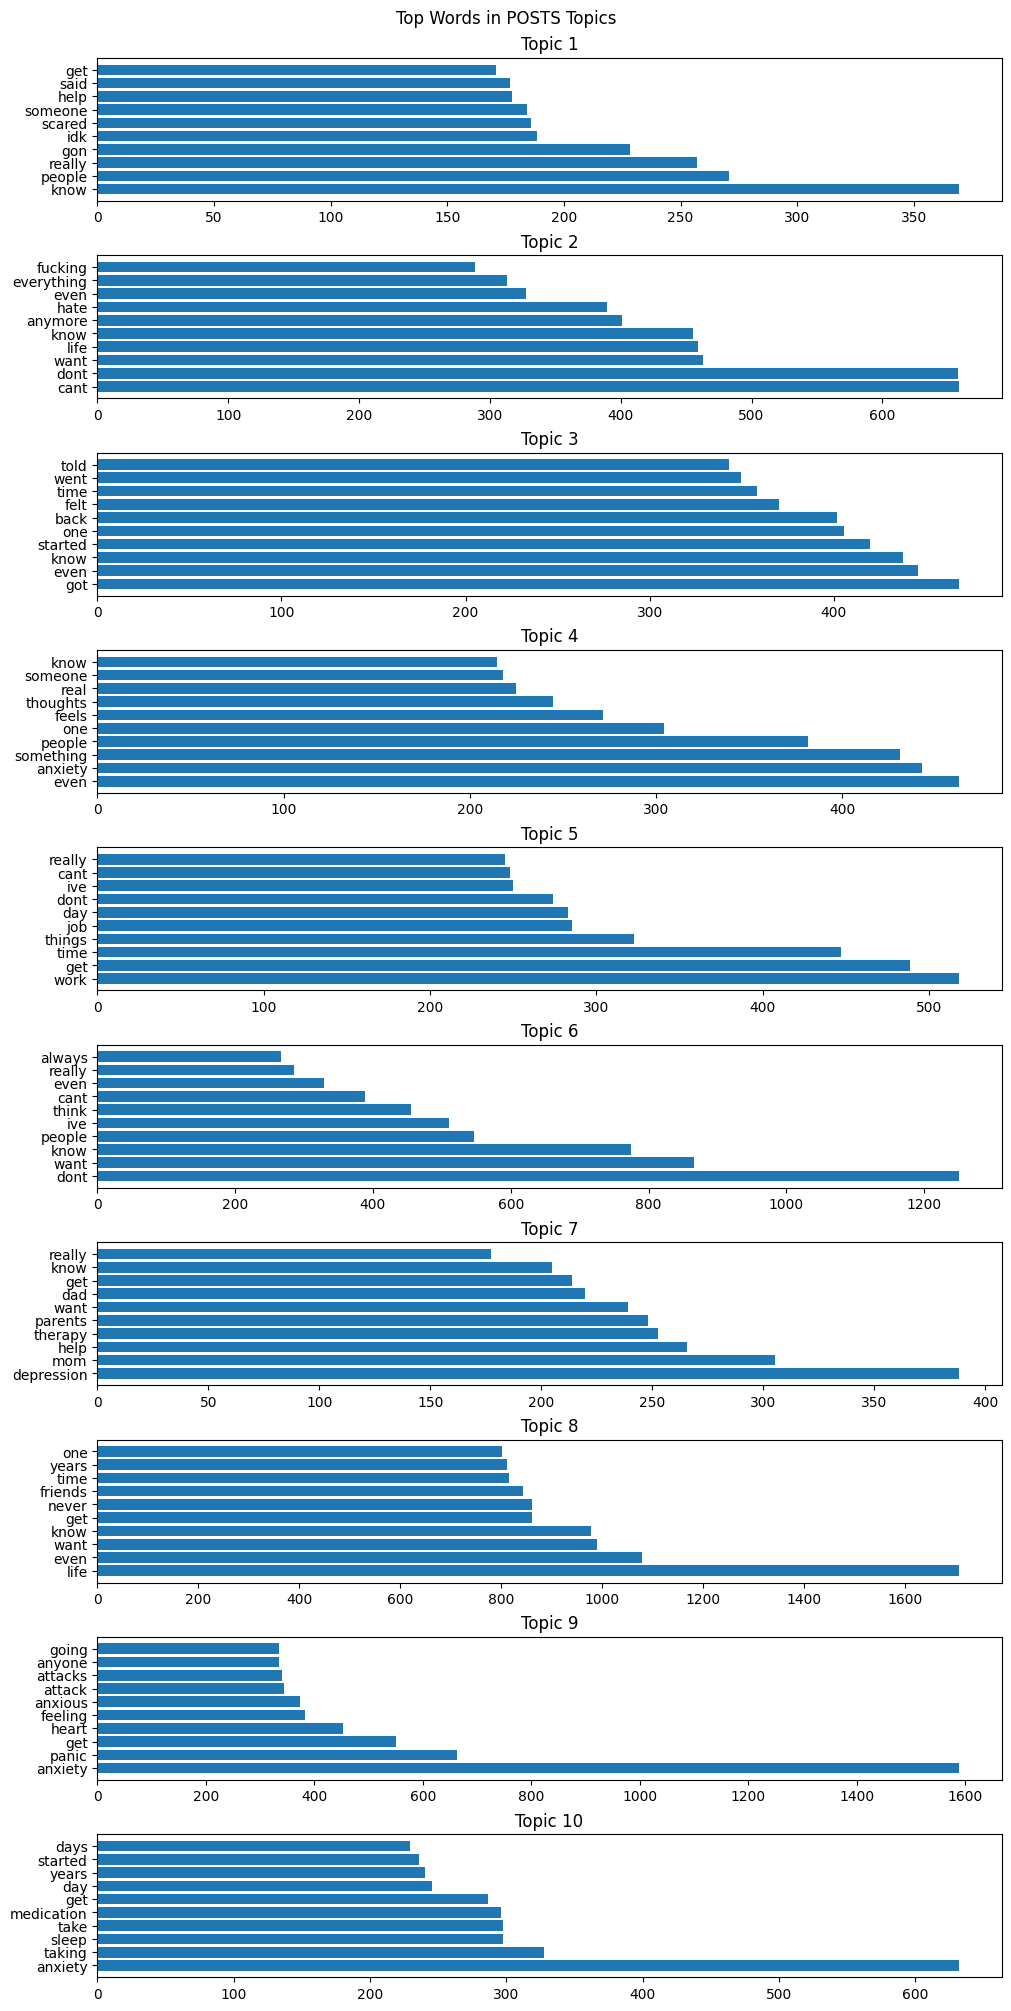

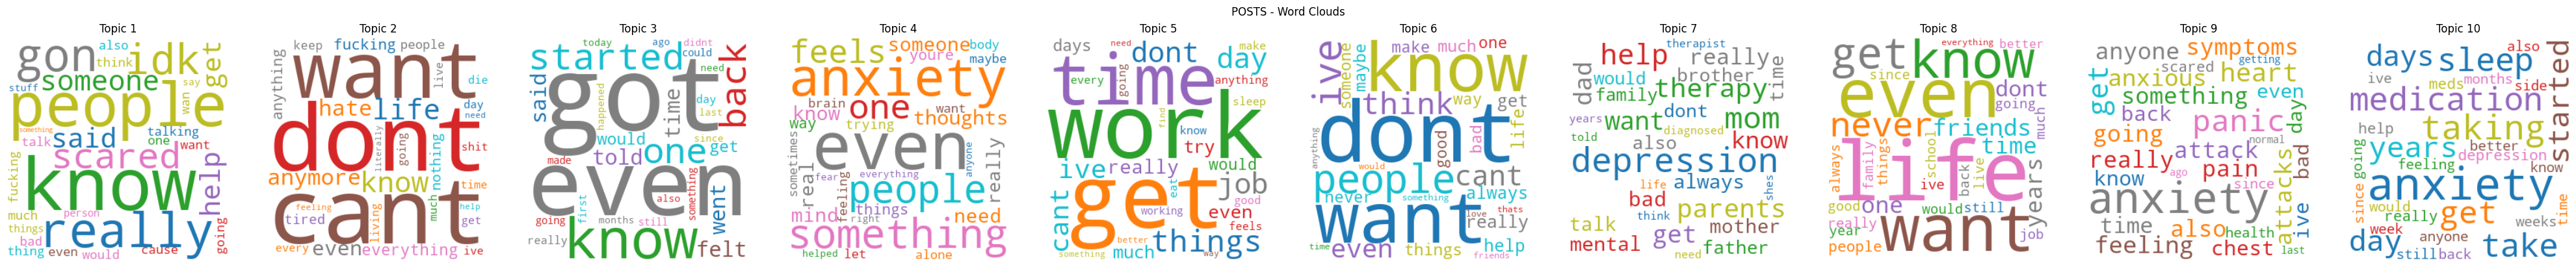


 Running LDA for COMMENTS (10580 documents)

 Topic 1: dont | love | people | world | know | way | much | think | war | life

 Topic 2: life | even | one | people | something | things | time | want | way | need

 Topic 3: people | get | help | know | dont | things | good | someone | would | need

 Topic 4: therapy | help | time | really | try | also | know | would | talk | say

 Topic 5: anxiety | mind | things | something | even | feeling | try | youre | breathing | body

 Topic 6: also | glad | reach | suicidal | come | sit | friends | relax | back | feeling

 Topic 7: get | time | day | anxiety | take | sleep | try | things | help | something

 Topic 8: professional | medical | treatment | changes | advice | doubt | ask | plans | note | anxiety

 Topic 9: anxiety | years | get | panic | would | also | started | going | time | take

 Topic 10: resources | listen | music | hello | youtube | stories | care | safe | content | personal
 Coherence Score: 0.6230


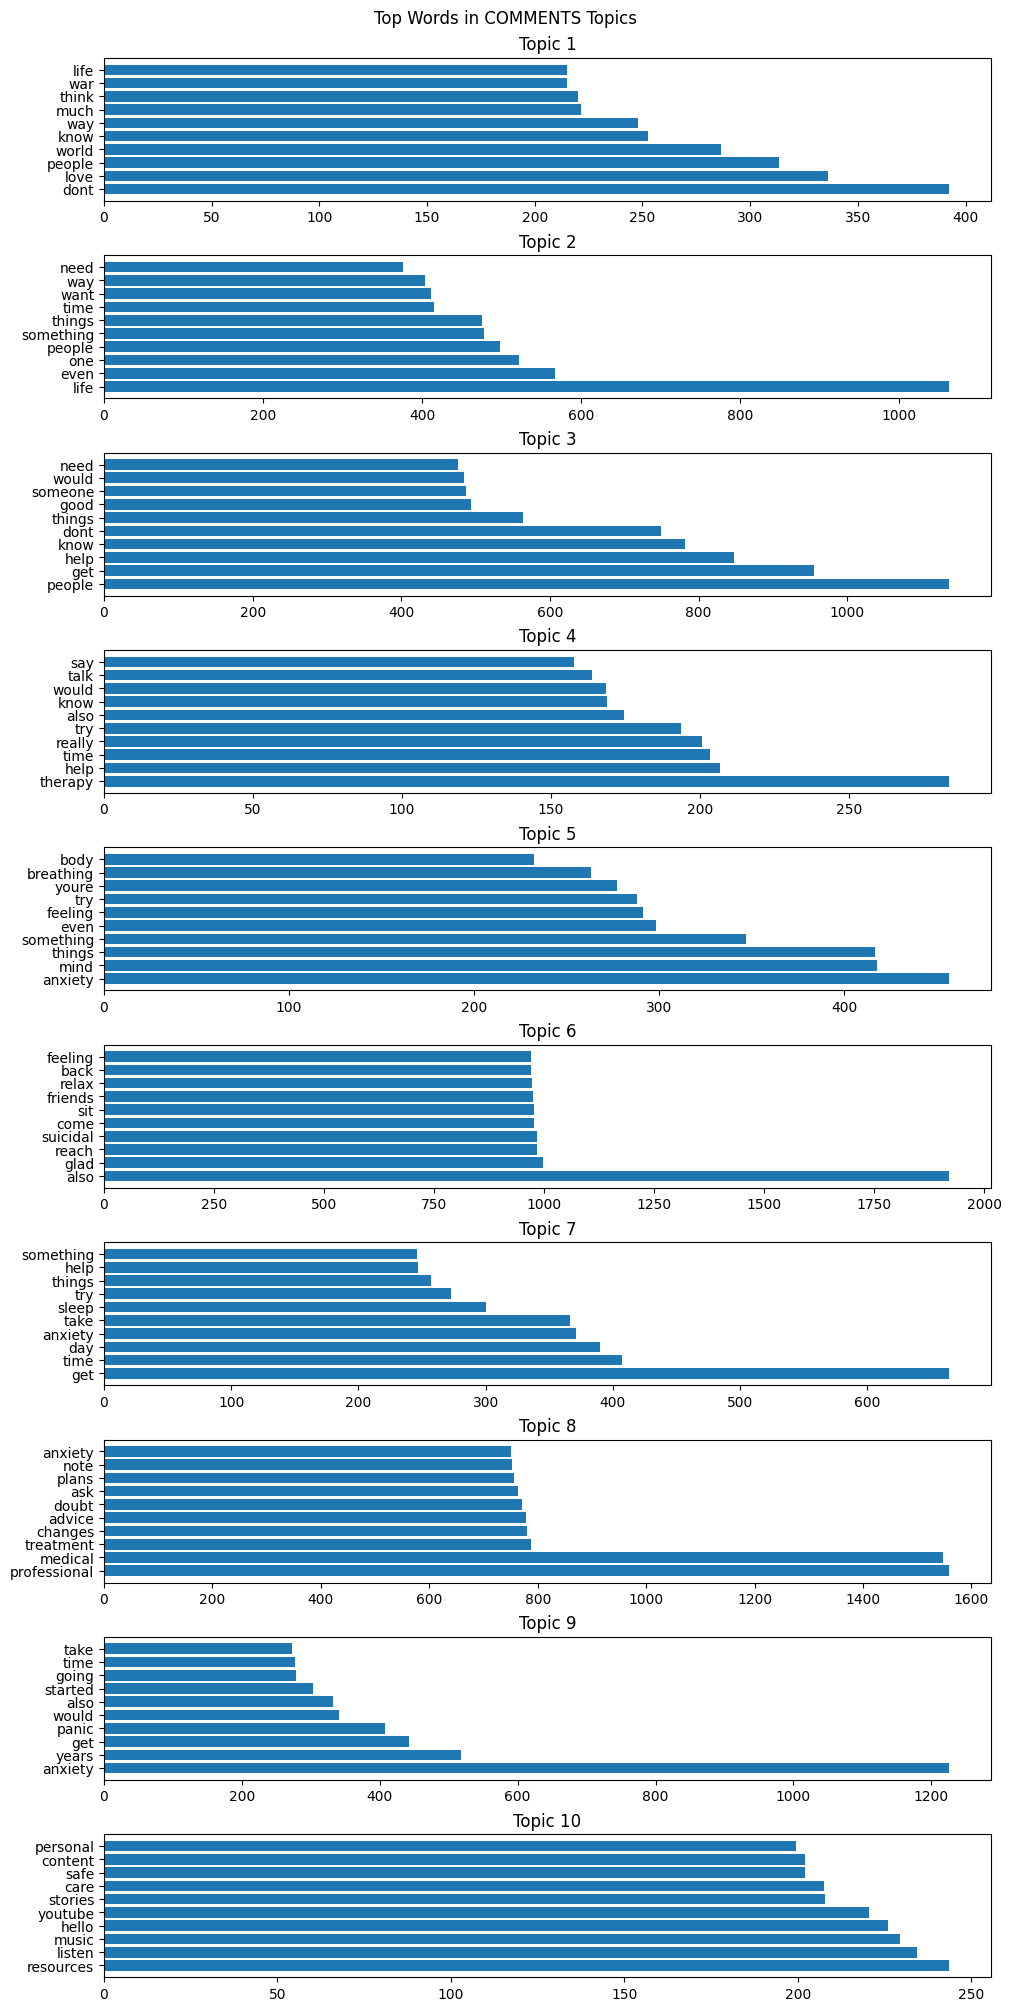

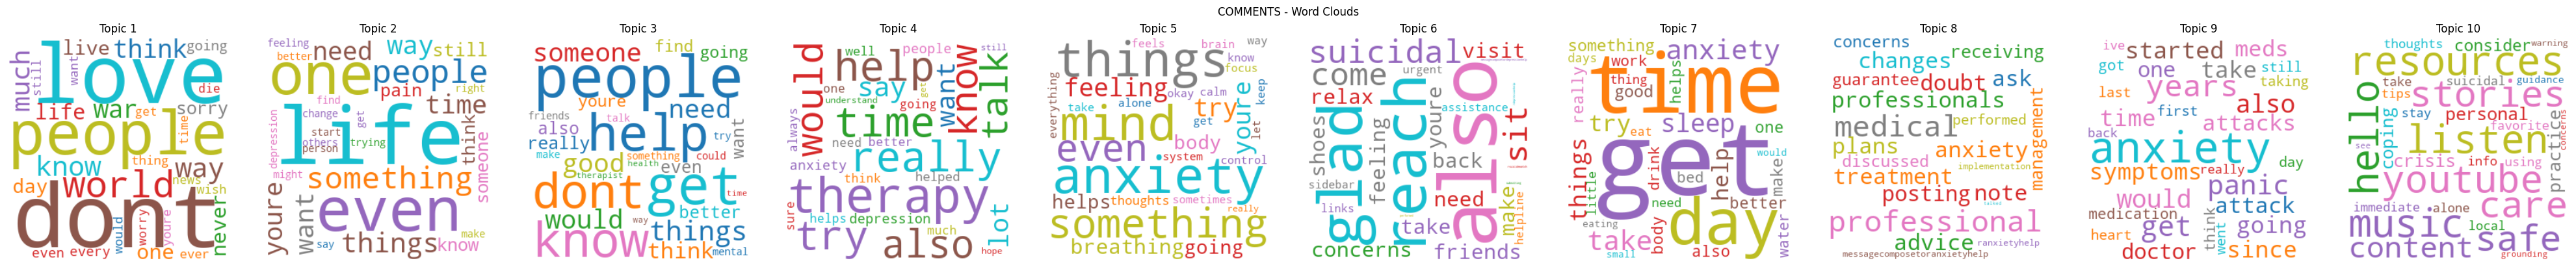

In [7]:
def load_documents(file_type="post"):
    """
    generates a documents list to be passed in the next function
    """
    docs = []
    for file in os.listdir(cleaned_data_folder):
        if file_type in file and file in posts_comments:
            df = pd.read_csv(os.path.join(cleaned_data_folder, file))
            if "clean_text" in df.columns:
                docs.extend(df["clean_text"].dropna().tolist())
    return docs

def display_topics(model, feature_names, no_top_words = 10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(f"\n Topic {topic_idx + 1}: {' | '.join(top_words)}")
        topics.append(top_words)
    return topics

def calculate_coherence(lda_model, texts, top_n = 10, random_state = seed):
    """
    Calculate c_v coherence score
    """
    # Create dictionary from texts
    dictionary = Dictionary(texts)
    
    # Extract topics from sklearn LDA model
    topics = []
    feature_names = vectorizer.get_feature_names_out()

    
    for topic in lda_model.components_:
        top_indices = topic.argsort()[:-top_n-1:-1]
        top_words = [feature_names[i] for i in top_indices if i < len(feature_names)]
        topics.append(top_words)
    
    # Calculate C_v coherence
    coherence_model = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    return coherence_model.get_coherence()

def plot_top_words_per_topic(lda_model, feature_names, no_top_words = 10, title = "Top Words per Topic"):
    """ 
    Plot top words for each topic in a horizontal bar chart
    """
    fig, axes = plt.subplots(nrows = NUM_TOPICS, ncols = 1, figsize = (10, 2 * NUM_TOPICS), constrained_layout = True)

    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]
        
        ax = axes[topic_idx]
        ax.barh(top_words[::-1], top_weights[::-1])
        ax.set_title(f"Topic {topic_idx + 1}")
        ax.invert_yaxis()

    fig.suptitle(title)
    plt.show()

def plot_wordclouds_per_topic(lda_model, feature_names, no_top_words=10, title="Word Clouds per Topic"):
    """ 
    Generate word clouds for each topic
    """
    fig, axes = plt.subplots(nrows=1, ncols=NUM_TOPICS, figsize=(4 * NUM_TOPICS, 4), constrained_layout=True)

    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = {feature_names[i]: topic[i] for i in top_indices}
        wc = WordCloud(background_color='white', colormap='tab10', width=300, height=300)
        wc.generate_from_frequencies(top_words)

        axes[topic_idx].imshow(wc, interpolation='bilinear')
        axes[topic_idx].axis('off')
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}")

    plt.suptitle(title)
    plt.show()

def run_lda(documents, label = ""):
    """ 
    Run LDA on the provided documents and display topics and coherence score
    """
    print(f"\n Running LDA for {label} ({len(documents)} documents)")

    dt_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    lda = LatentDirichletAllocation(
        n_components=NUM_TOPICS,
        random_state=seed,
        learning_method = "batch"
    )
    lda.fit(dt_matrix)

    topics = display_topics(lda, feature_names, no_top_words=TOP_N_WORDS)

    # Tokenize documents for coherence calculation
    tokenized_docs = [word_tokenize(doc.lower()) for doc in documents]

    coherence_score = calculate_coherence(lda, tokenized_docs, top_n=TOP_N_WORDS)
    print(f" Coherence Score: {coherence_score:.4f}")

    plot_top_words_per_topic(lda, feature_names, no_top_words = TOP_N_WORDS, title = f"Top Words in {label} Topics")
    plot_wordclouds_per_topic(lda, feature_names, no_top_words=30, title=f"{label} - Word Clouds")

post_docs = load_documents("post")
comment_docs = load_documents("comment")

run_lda(post_docs, label="POSTS")
run_lda(comment_docs, label="COMMENTS")


#### 3. GENERAL SENTIMENT ANALYSIS

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     c:\Users\carru\Desktop\css project\venv\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Analyzing Sentiment: 100%|██████████| 1809/1809 [00:00<00:00, 2600.24it/s]


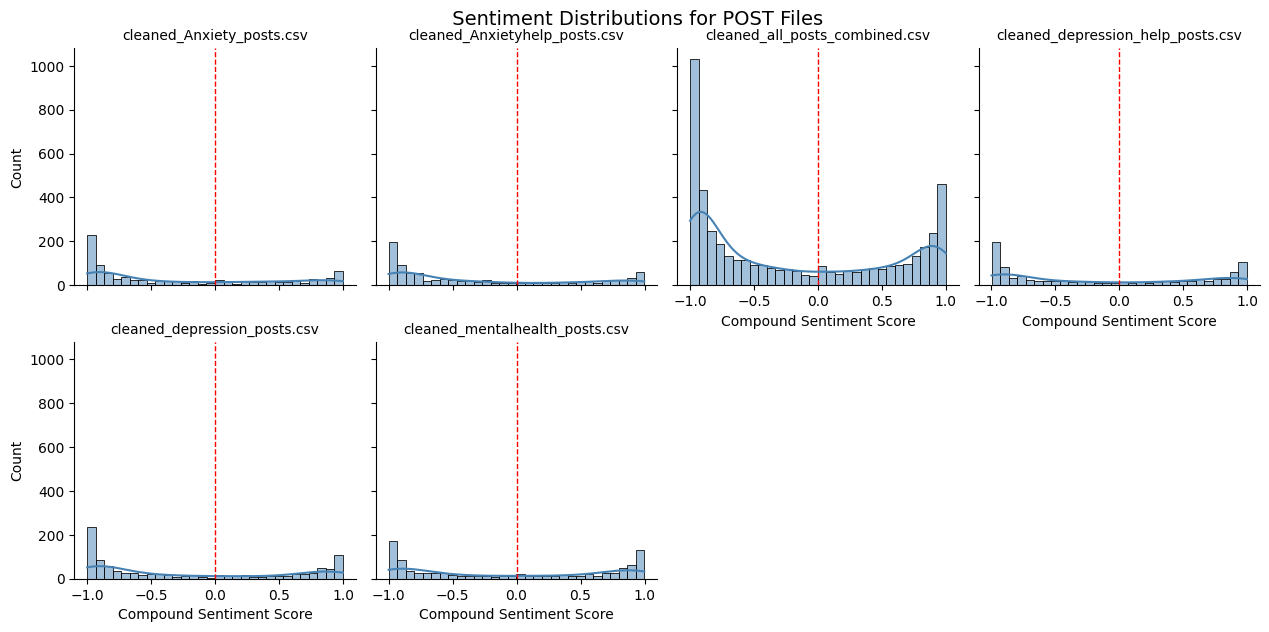

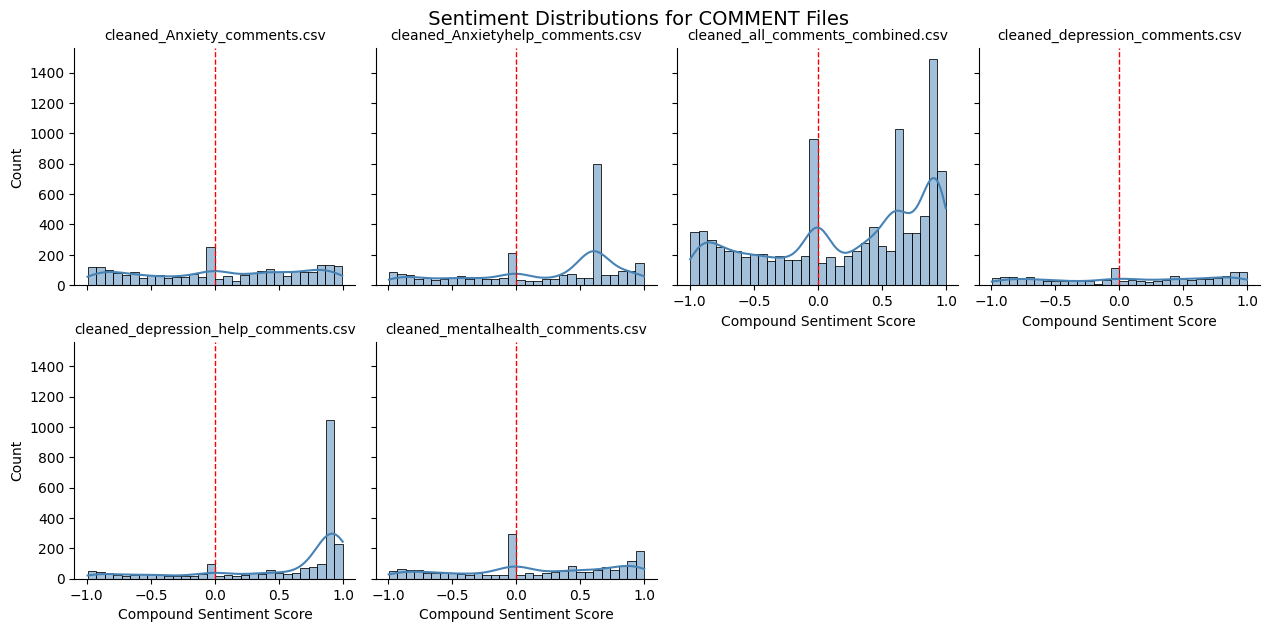

In [8]:
nltk.download('vader_lexicon')

# Initialize VADER
vader = SentimentIntensityAnalyzer()

def analyze_sentiment(documents):
    """
    Returns a list with the sentiment scores of each instance
    in the documents defined in the next function
    """
    sentiments = []
    for text in tqdm(documents, desc="Analyzing Sentiment"):
        scores = vader.polarity_scores(str(text))
        sentiments.append(scores['compound'])
    return sentiments

def collect_sentiments_by_file(folder_path, file_type="post"):
    """
    access and analyze the sentiment of the preprocessed text in the files
    """
    data = []

    for file in sorted(os.listdir(folder_path)):
        if file_type in file and file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            documents = df["clean_text"].dropna().tolist()
            sentiments = analyze_sentiment(documents)

            for score in sentiments:
                data.append({"Sentiment": score, "File": file})
    
    return pd.DataFrame(data)

def plot_facet_sentiment_distributions(df, title):
    g = sns.FacetGrid(df, col="File", col_wrap=4, height=3.2, sharex=True, sharey=True)
    g.map(sns.histplot, "Sentiment", bins=30, kde=True, color="steelblue")
    g.set_titles(col_template="{col_name}", size=10)
    g.set_axis_labels("Compound Sentiment Score", "Count")
    g.figure.subplots_adjust(top=0.92)
    g.figure.suptitle(title, fontsize=14)
    for ax in g.axes.flatten():
        ax.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.show()

df_posts = collect_sentiments_by_file(cleaned_data_folder, file_type="post")
df_comments = collect_sentiments_by_file(cleaned_data_folder, file_type="comment")

plot_facet_sentiment_distributions(df_posts, title=" Sentiment Distributions for POST Files")
plot_facet_sentiment_distributions(df_comments, title=" Sentiment Distributions for COMMENT Files")

Sentiment distribution for posts is overall quite balanced, with two peaks at the extremes (negative and positive), the subreddits reflects this balance, with the exception of the ones related to anxiety, slightly skewed towards negative. This is a bit surprising since I would expect the sentiment be mostly negative, especially in "stronger" communities like "r/depression". 

The comments are skewed towards positive, it's likely in fact that those are comments of support for the person who share their situation in the posts. this hypothesis seems more valid in the "r/depression_help" community, while the "r/depression" community seems balanced.



#### 4. BERTOPIC AND DOMAIN SPECIFIC SENTIMENT ANALYSIS

In [9]:
unique_bigrams = bigrams_df["bigram"].drop_duplicates().reset_index(drop=True)
unique_bigrams


0      panic attacks
1       panic attack
2       side effects
3      mental health
4     health anxiety
5          every day
6          dont know
7          good luck
8         heart rate
9          years ago
10       anyone else
11       even though
12      social media
13         kalm mind
14         mind hack
15    nervous system
16        get better
17         one thing
18         dont want
19        first time
20           one day
21      rapists suck
22       gets better
23        dont think
24          dont get
25       youre going
26         hope find
27       hurts hurts
28         cant even
29        keep going
30         take care
31      someone else
32         wish best
33        little bit
34         dont even
35        every time
36         need help
37         long time
38       many people
39        ever since
Name: bigram, dtype: object

In [11]:
# --- Configuration ---
posts_comments = ["cleaned_all_posts_combined.csv", "cleaned_all_comments_combined.csv"]

cleaned_data_folder = "../references/data_cleaned" 
topic_assignments_folder = "../references/tables_figures/bertopic" 

NUM_TOPICS = 10 
seed = 77 
top_n_words_coherence = 10 
top_n_empath_categories = 10 

os.makedirs(topic_assignments_folder, exist_ok=True)

empath_analyzer = Empath()

# Define seed terms for custom mental health categories, some words taken from uni-bigrams
seed_terms_anxiety_crisis = ["panic attack", "panick attacks", "anxiety attack", "overwhelmed", "can't breathe", "heart racing", "side effects"]
empath_analyzer.create_category("anxiety_crisis", seed_terms_anxiety_crisis, model="reddit")

seed_terms_depression = ["feeling down", "hopeless", "can't get out of bed", "crying", "no energy", "side effects"]
empath_analyzer.create_category("depression_symptoms", seed_terms_depression, model="reddit")

seed_terms_self_harm = ["self harm", "cut myself", "hurt myself", "scar", "razor"]
empath_analyzer.create_category("self_harm_references", seed_terms_self_harm, model="reddit")

seed_terms_recovery = ["getting better", "making progress", "feeling stronger", "hopeful", "healing journey", "good luck", "get better", "gets better", 
                       "recovery", "recovered", "healing", "improvement", "progress", "keep going"]
empath_analyzer.create_category("recovery_progress", seed_terms_recovery, model="reddit")


["overwhelmed", "overwhelmed", "overwhelming", "stressed", "frustrated", "anxious", "stressed", "discouraged", "panicky", "disheartened", "disheartened", "frazzled", "exhausted", "daunting", "daunting", "demotivated", "feeling", "exhausting", "panicked", "antsy", "exhausted", "demotivated", "relieved", "daunted", "hopeless", "distracted", "disorganized", "frustrated", "overwhelming", "depressed", "nervous", "uneasy", "huge_relief", "stressful", "whelmed", "trapped", "unfocused", "unnerved", "despondent", "impatient", "bored", "lost", "despairing", "nervous_wreck", "terrified", "discouraging", "scatterbrained", "frustrating", "frightened", "tired", "unprepared", "restless", "flustered", "defeated", "unsettled", "numbed", "stressing", "agitated", "swamped", "apprehensive", "dread", "hectic", "understandably", "lonely", "scared", "intimidated", "exhausting", "panicking", "scatterbrained", "frustrating", "disorganized", "irritable", "so_much_anxiety", "cathartic", "new_feelings", "unsatisf

--- Loading documents for BERTopic analysis ---


2025-07-01 12:08:42,909 - BERTopic - Embedding - Transforming documents to embeddings.



--- Running BERTopic for POSTS (4649 documents) ---


Batches: 100%|██████████| 146/146 [01:27<00:00,  1.66it/s]
2025-07-01 12:10:20,263 - BERTopic - Embedding - Completed ✓
2025-07-01 12:10:20,263 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-01 12:10:48,539 - BERTopic - Dimensionality - Completed ✓
2025-07-01 12:10:48,539 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-01 12:10:48,662 - BERTopic - Cluster - Completed ✓
2025-07-01 12:10:48,662 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-07-01 12:10:49,023 - BERTopic - Representation - Completed ✓
2025-07-01 12:10:49,023 - BERTopic - Topic reduction - Reducing number of topics
2025-07-01 12:10:49,023 - BERTopic - Topic reduction - Number of topics (10) is equal or higher than the clustered topics(8).
2025-07-01 12:10:49,023 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-01 12:10:49,463 - BERTopic - Representation - Completed ✓



--- BERTopic Info for POSTS (Top 11 topics) ---
    Topic  Count                            Name  \
0     -1    152        -1_anxiety_get_like_feel   
1      0     22    0_teeth_dentist_dental_tooth   
2      1     20         1_hair_cut_scalp_barber   
3      2     28  2_shower_room_clean_disgusting   
4      3     12            3_rabies_cat_vet_got   
5      4     11          4_drunk_going_feel_ocd   
6      5     31   5_flight_flying_plane_anxiety   
7      6   4373           6_like_feel_know_even   

                                      Representation  
0  [anxiety, get, like, feel, work, ive, time, do...  
1  [teeth, dentist, dental, tooth, appointment, d...  
2  [hair, cut, scalp, barber, lice, day, bad, hea...  
3  [shower, room, clean, disgusting, showering, d...  
4  [rabies, cat, vet, got, bat, said, days, bit, ...  
5  [drunk, going, feel, ocd, like, months, ive, e...  
6  [flight, flying, plane, anxiety, travel, anxio...  
7  [like, feel, know, even, get, dont, want, life.

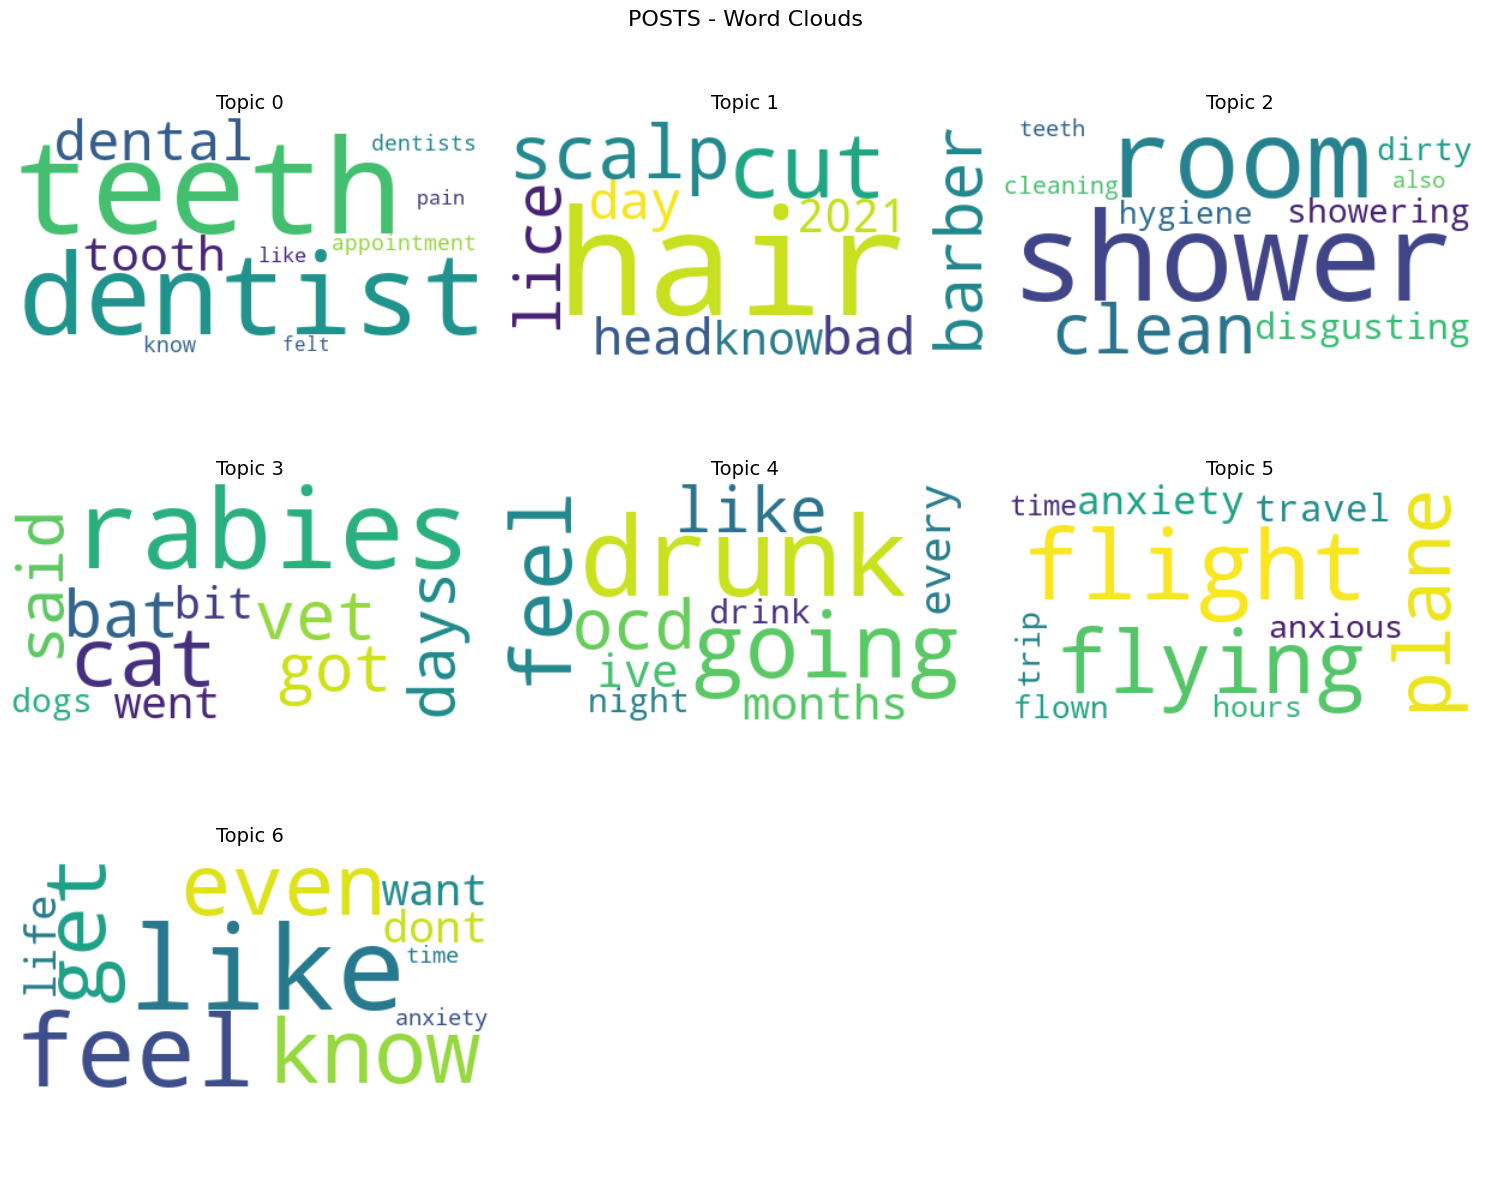

2025-07-01 12:11:03,271 - BERTopic - Embedding - Transforming documents to embeddings.


Topic assignments saved to: ../references/tables_figures/bertopic\posts_topics.csv

--- Running BERTopic for COMMENTS (10580 documents) ---


Batches: 100%|██████████| 331/331 [01:29<00:00,  3.68it/s]
2025-07-01 12:12:35,566 - BERTopic - Embedding - Completed ✓
2025-07-01 12:12:35,566 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-01 12:12:43,219 - BERTopic - Dimensionality - Completed ✓
2025-07-01 12:12:43,222 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-01 12:12:43,442 - BERTopic - Cluster - Completed ✓
2025-07-01 12:12:43,442 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-07-01 12:12:43,823 - BERTopic - Representation - Completed ✓
2025-07-01 12:12:43,823 - BERTopic - Topic reduction - Reducing number of topics
2025-07-01 12:12:43,881 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-01 12:12:44,170 - BERTopic - Representation - Completed ✓
2025-07-01 12:12:44,185 - BERTopic - Topic reduction - Reduced number of topics from 111 to 10



--- BERTopic Info for COMMENTS (Top 11 topics) ---
    Topic  Count                                  Name  \
0     -1   3706               -1_like_feel_get_people   
1      0   3811               0_like_anxiety_feel_get   
2      1   1735  1_please_performed_bot_automatically   
3      2    400      2_drink_alcohol_caffeine_anxiety   
4      3    355                 3_talk_sorry_hug_feel   
5      4    347                4_war_iran_ww3_nuclear   
6      5    107           5_like_music_rain_adventure   
7      6     74      6_rapists_suck_rapist_experience   
8      7     23        7_birthday_happy_birthdays_day   
9      8     22             8_protein_eat_easy_cheese   

                                      Representation  
0  [like, feel, get, people, things, life, even, ...  
1  [like, anxiety, feel, get, people, know, time,...  
2  [please, performed, bot, automatically, concer...  
3  [drink, alcohol, caffeine, anxiety, like, cold...  
4  [talk, sorry, hug, feel, alone, want, lik

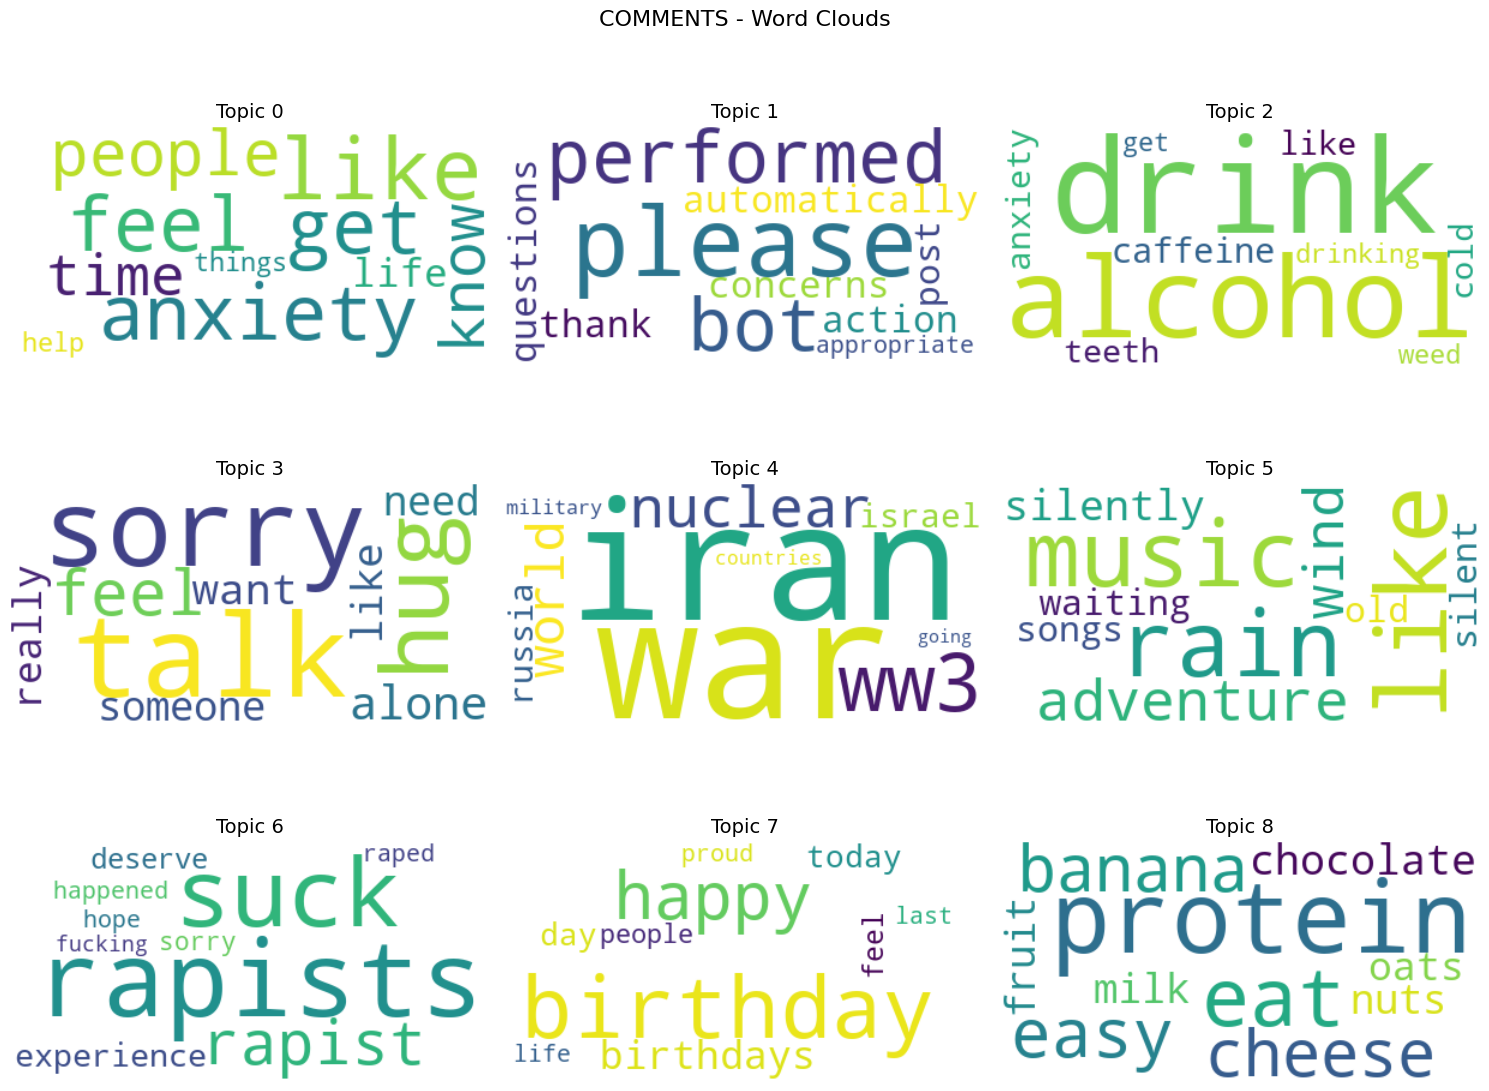

Topic assignments saved to: ../references/tables_figures/bertopic\comments_topics.csv

--- Applying Empath to Posts Data ---
Analyzing Empath categories for 4649 documents...

--- Applying Empath to Comments Data ---
Analyzing Empath categories for 10580 documents...

--- Overall Average Empath Category Proportions (Posts) ---
Empath_negative_emotion    0.050488
Empath_nervousness         0.040871
Empath_pain                0.036423
Empath_health              0.030691
Empath_violence            0.030449
Empath_shame               0.029892
Empath_sadness             0.028945
Empath_positive_emotion    0.026252
Empath_suffering           0.025989
Empath_fear                0.024726
dtype: float64

--- Overall Average Empath Category Proportions (Comments) ---
Empath_health              0.035375
Empath_negative_emotion    0.031815
Empath_nervousness         0.030248
Empath_positive_emotion    0.029661
Empath_communication       0.027856
Empath_sadness             0.024319
Empath_fear     

In [12]:
# --- Data Loading Function for BERTopic and Empath ---
def load_documents_for_analysis(folder_path, file_type="post"):
    """
    Loads cleaned text documents from CSV files in the specified folder,
    and prepares them for both BERTopic and Empath analysis.
    Returns a list of clean texts and a DataFrame with metadata.
    """
    all_docs_list = []
    all_metadata_dfs = []
    text_col_map = {"post": "selftext", "comment": "body"}
    id_col_map = {"post": "post_id", "comment": "comment_id"}

    for file in sorted(os.listdir(folder_path)):
        if file_type in file and file in posts_comments:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            current_text_col = text_col_map.get(file_type)
            current_id_col = id_col_map.get(file_type)

            if current_text_col not in df.columns or "clean_text" not in df.columns:
                print(f"Warning: Required columns not found in {file}. Skipping {file}.")
                continue

            # Filter out NaN or empty strings from clean_text before processing
            df_filtered = df.dropna(subset=["clean_text"]).copy()
            df_filtered = df_filtered[df_filtered["clean_text"].astype(str).str.strip() != ""]

            if df_filtered.empty:
                print(f"Warning: No valid clean_text found in {file}. Skipping {file}.")
                continue

            all_docs_list.extend(df_filtered["clean_text"].tolist())

            # Prepare metadata DataFrame for linking
            temp_meta_df = df_filtered[[current_id_col, current_text_col, "clean_text"]].copy()
            temp_meta_df.rename(columns={current_id_col: "ID", current_text_col: "Original_Text"}, inplace=True)
            temp_meta_df['File'] = file 
            all_metadata_dfs.append(temp_meta_df)

    if all_metadata_dfs:
        return all_docs_list, pd.concat(all_metadata_dfs, ignore_index=True)
    else:
        return [], pd.DataFrame()


# --- BERTopic and Visualization Functions ---
def plot_wordclouds_per_topic(bert_model, no_top_words=30, title=None):
    """Generates and displays word clouds for each topic."""
    topics = bert_model.get_topics()

    # Exclude outlier topic (-1) and sort by topic id
    topic_items = [(tid, words) for tid, words in topics.items() if tid != -1]
    n_topics = len(topic_items)

    # asjust for better visualization
    n_cols = 3
    n_rows = (n_topics + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, (topic_id, words) in enumerate(topic_items):
        # Prevent index out of bounds if n_topics is large
        if idx >= len(axes): 
            break
        word_freq = {word: weight for word, weight in words[:no_top_words]}

        # Check if word_freq is not empty to avoid errors with empty word clouds
        if word_freq:
            wc = WordCloud(background_color='white', collocations=False).generate_from_frequencies(word_freq)
            axes[idx].imshow(wc, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f"Topic {topic_id}", fontsize=14)

    # Hide unused axes
    for ax in axes[n_topics:]:
        ax.axis('off')

    if title:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def run_bertopic(docs_list, docs_df, label, num_topics_param):
    """
    Runs BERTopic model, calculates coherence, and saves topic assignments.
    Returns the fitted BERTopic model and the DataFrame with topic assignments.
    """
    print(f"\n--- Running BERTopic for {label} ({len(docs_list)} documents) ---")

    # Initialize UMAP and HDBSCAN models
    # n_components can be specified in umap for potential better clustering
    umap_model = UMAP(random_state=seed) 
    hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom') # Adjusted for better topic detection

    bert = BERTopic(
        nr_topics=num_topics_param, 
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=True
    )
    topics, probs = bert.fit_transform(docs_list)

    docs_df['topic_id'] = topics

    # Topic info, remove Representative_Docs to avoid identification
    info = bert.get_topic_info().drop(columns=["Representative_Docs"], errors="ignore")
    print(f"\n--- BERTopic Info for {label} (Top {num_topics_param + 1} topics) ---\n", info.head(num_topics_param + 1))

    # Coherence evaluation
    top_word_lists = []
    # Get all topic ids except outlier (-1) which is usually noise
    topic_ids = [tid for tid in bert.get_topics().keys() if tid != -1]

    for t in topic_ids:
        topic_words = bert.get_topic(t)

        # Only add if topic_words is a non-empty list
        if topic_words and isinstance(topic_words, list):
            tokens = [w for w, _ in topic_words[:top_n_words_coherence]]

            if tokens:  
                top_word_lists.append(tokens)

    # Tokenize documents for coherence calculation
    tokenized_docs = [word_tokenize(doc.lower()) for doc in docs_list]
    dictionary = Dictionary(tokenized_docs)

    # Only pass non-empty topics to CoherenceModel
    coherence = float('nan')
    if top_word_lists:
        try:
            coherence_model = CoherenceModel(
                topics=top_word_lists,
                texts=tokenized_docs,
                dictionary=dictionary,
                coherence='c_v'
            )
            coherence = coherence_model.get_coherence()
        except Exception as e:
            print(f"Error calculating coherence for {label}: {e}")

    print(f"c_v Coherence for {label}: {coherence:.4f}")

    # Visualizations
    fig = bert.visualize_barchart(top_n_topics=num_topics_param, n_words=10, width=250, height=400)
    fig.update_layout(title_text=f"{label} – Top Words per Topic")
    fig.show()
    plot_wordclouds_per_topic(bert, no_top_words=30, title=f"{label} - Word Clouds")

    # Save topic assignments for later use
    output_filename = f"{label.lower()}_topics.csv"
    docs_df[['ID', 'topic_id']].to_csv(os.path.join(topic_assignments_folder, output_filename), index=False)
    print(f"Topic assignments saved to: {os.path.join(topic_assignments_folder, output_filename)}")

    return bert, docs_df

# --- Empath Analysis Function (Modified from previous Canvas) ---
def apply_empath_analysis_to_df(df_to_analyze, empath_analyzer=None):
    """
    Collects Empath category scores for a given DataFrame and adds them as new columns.
    Assumes 'clean_text' column exists in df_to_analyze.
    """
    if df_to_analyze.empty or empath_analyzer is None:
        print("DataFrame is empty or Empath analyzer not provided. Skipping Empath analysis.")
        return df_to_analyze

    print(f"Analyzing Empath categories for {len(df_to_analyze)} documents...")
    
    # Empath's analyze method returns a dict of scores
    empath_results = df_to_analyze['clean_text'].apply(lambda x: empath_analyzer.analyze(str(x), normalize=True))

    # Normalize Empath results: fill missing categories with 0
    # First, collect all possible Empath categories from the results
    all_empath_categories = set()
    for res_dict in empath_results:
        if res_dict: 
            all_empath_categories.update(res_dict.keys())
    
    # Create a new DataFrame from the Empath results, filling missing values
    empath_df = pd.DataFrame(empath_results.tolist(), index=df_to_analyze.index)
    empath_df = empath_df.fillna(0)

    # Rename columns to avoid clashes and indicate Empath source
    empath_df.columns = [f"Empath_{col}" for col in empath_df.columns]
    
    # Concatenate Empath scores with the original DataFrame
    df_with_empath = pd.concat([df_to_analyze, empath_df], axis=1)
    
    return df_with_empath


# --- Main Execution Flow ---

# Load Documents for the two files
print("--- Loading documents for BERTopic analysis ---")
posts_list, df_posts_metadata = load_documents_for_analysis(cleaned_data_folder, "post")
comments_list, df_comments_metadata = load_documents_for_analysis(cleaned_data_folder, "comment")

#  Run BERTopic and Save Topic Assignments
bert_posts, df_posts_with_topics = run_bertopic(posts_list, df_posts_metadata, "POSTS", NUM_TOPICS)
bert_comments, df_comments_with_topics = run_bertopic(comments_list, df_comments_metadata, "COMMENTS", NUM_TOPICS)

#  Apply Empath Analysis to the DataFrames
print("\n--- Applying Empath to Posts Data ---")
df_posts_empath_full = apply_empath_analysis_to_df(df_posts_with_topics, empath_analyzer)
print("\n--- Applying Empath to Comments Data ---")
df_comments_empath_full = apply_empath_analysis_to_df(df_comments_with_topics, empath_analyzer)

# Get all Empath categories (pre-built + custom)
all_empath_categories_names = [f"Empath_{cat}" for cat in empath_analyzer.cats.keys()]
existing_empath_cols_posts = [col for col in all_empath_categories_names if col in df_posts_empath_full.columns]
existing_empath_cols_comments = [col for col in all_empath_categories_names if col in df_comments_empath_full.columns]

# Overall Average Empath Category Proportions (Posts)
if not df_posts_empath_full.empty and existing_empath_cols_posts:
    print("\n--- Overall Average Empath Category Proportions (Posts) ---")
    overall_avg_empath_posts = df_posts_empath_full[existing_empath_cols_posts].mean().sort_values(ascending=False).head(top_n_empath_categories)
    print(overall_avg_empath_posts)

# Overall Average Empath Category Proportions (Comments)
if not df_comments_empath_full.empty and existing_empath_cols_comments:
    print("\n--- Overall Average Empath Category Proportions (Comments) ---")
    overall_avg_empath_comments = df_comments_empath_full[existing_empath_cols_comments].mean().sort_values(ascending=False).head(top_n_empath_categories)
    print(overall_avg_empath_comments)

# -----------------------------------

# Most Frequent Empath Categories per file for Posts
# to be included only if changing the posts_comments variable to include other files/subreddits
#if not df_posts_empath_full.empty and existing_empath_cols_posts:
 #   print("\n--- Most Frequent Empath Category Proportions PER FILE (Subreddit) for Posts ---")
 #   avg_empath_per_file_posts = df_posts_empath_full.groupby('File')[existing_empath_cols_posts].mean()
 #   for file_name, row in avg_empath_per_file_posts.iterrows():
  #      print(f"\nFile: {file_name}")
  #      top_categories = row.sort_values(ascending=False).head(top_n_empath_categories)
 #       print(top_categories)

# Most Frequent Empath Category Proportions per file for Comments
#if not df_comments_empath_full.empty and existing_empath_cols_comments:
 #   print("\n--- Most Frequent Empath Category Proportions per file for Comments ---")
 #   avg_empath_per_file_comments = df_comments_empath_full.groupby('File')[existing_empath_cols_comments].mean()
 #   for file_name, row in avg_empath_per_file_comments.iterrows():
 #       print(f"\nFile: {file_name}")
 #       top_categories = row.sort_values(ascending=False).head(top_n_empath_categories)
 #       print(top_categories)

# -----------------------------------

# Applying Empath to BERTopic Topics 

# For Posts
if not df_posts_empath_full.empty and existing_empath_cols_posts:

    # Filter out topic_id -1 (outlier topic) before aggregation
    print("\n--- Average Empath Category Proportions PER TOPIC (Posts) ---")
    df_posts_empath_full_filtered = df_posts_empath_full[df_posts_empath_full['topic_id'] != -1].copy()
    
    # Ensure topic_id is an integer to avoid mismatchs
    if not df_posts_empath_full_filtered.empty:
        df_posts_empath_full_filtered['topic_id'] = df_posts_empath_full_filtered['topic_id'].astype(int)
        avg_empath_per_topic_posts = df_posts_empath_full_filtered.groupby('topic_id')[existing_empath_cols_posts].mean()
        
        # only print out the top categories for each topic
        for topic_id, row in avg_empath_per_topic_posts.iterrows():
            print(f"\nTopic ID: {topic_id}")
            top_categories = row.sort_values(ascending=False).head(top_n_empath_categories)
            print(top_categories)
    else:
        print("No non-outlier data to aggregate Empath scores by topic for posts.")

# For Comments
if not df_comments_empath_full.empty and existing_empath_cols_comments:
    print("\n--- Average Empath Category Proportions PER TOPIC (Comments) ---")
    
    # same logic of posts
    df_comments_empath_full_filtered = df_comments_empath_full[df_comments_empath_full['topic_id'] != -1].copy()

    if not df_comments_empath_full_filtered.empty:
        df_comments_empath_full_filtered['topic_id'] = df_comments_empath_full_filtered['topic_id'].astype(int)
        avg_empath_per_topic_comments = df_comments_empath_full_filtered.groupby('topic_id')[existing_empath_cols_comments].mean()
        
        for topic_id, row in avg_empath_per_topic_comments.iterrows():
            print(f"\nTopic ID: {topic_id}")
            top_categories = row.sort_values(ascending=False).head(top_n_empath_categories)
            print(top_categories)
    else:
        print("No non-outlier data to aggregate Empath scores by topic for comments.")
